# Packages

In [25]:
!pip install torchmetrics tqdm --upgrade

# Imports

In [26]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics.text import Perplexity

import tqdm

from collections import Counter

# Configuration

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seq_len = 50
batch_size = 25
min_freq = 0

num_epochs = 300

max_lr_dec = 3
lr_dec = 0

# Utils

In [28]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [29]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# Dataset

## Download Dataset

In [31]:
tokenizer = get_tokenizer("basic_english")

In [32]:
def load_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        dataset = file.read()
    return dataset

def tokenize_dataset(dataset):
    tokens = []
    for line in dataset.split('\n'):
        line_tokens = tokenizer(line.strip())
        tokens.extend(line_tokens)
    return tokens

In [33]:
train_dataset = load_dataset("./penn/train.txt")
valid_dataset = load_dataset("./penn/valid.txt")
test_dataset = load_dataset("./penn/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

all_tokens = train_tokens + valid_tokens + test_tokens
print("Train Tokens: " , len(train_tokens))
print("Valid Tokens: " , len(valid_tokens))
print("Test Tokens: " , len(test_tokens))
print("Total number of tokens:", len(all_tokens))

Train Tokens:  924412
Valid Tokens:  73339
Test Tokens:  82114
Total number of tokens: 1079865


In [34]:
tokenized_datasets = [train_tokens] 

special_tokens = ['<pad>', '<unk>', '<bos>', '<eos>']

vocab = build_vocab_from_iterator(tokenized_datasets, specials=special_tokens , min_freq=min_freq)

vocab.set_default_index(vocab['<unk>'])

vocab_size = len(vocab)
vocab_itos = vocab.get_itos()

torch.save(vocab, f"./train_vocab_moses_{min_freq}.voc")
print("Vocabulary size:", vocab_size)

Vocabulary size: 9925


## Custom Dataset

In [35]:
class Wikitext2Dataset(Dataset):
  def __init__(self, tokens, seq_len):
    self.tokens = tokens
    self.seq_len = seq_len
  def __len__(self):
    return  len(self.tokens) // self.seq_len

  def __getitem__(self, idx):
    start_idx = idx * self.seq_len
    end_idx = start_idx + self.seq_len
    input = self.tokens[start_idx:end_idx]
    target = self.tokens[start_idx+1:end_idx+1]
    return torch.tensor(input), torch.tensor(target)

## Load Dataset

In [36]:
train_tokens_voc = vocab(train_tokens)
valid_tokens_voc = vocab(valid_tokens)
test_tokens_voc = vocab(test_tokens)

# Datasets
train_dataset = Wikitext2Dataset(train_tokens_voc, seq_len)
valid_dataset = Wikitext2Dataset(valid_tokens_voc, seq_len)
test_dataset = Wikitext2Dataset(test_tokens_voc, seq_len)

# Dataloaders
train_loader = DataLoader(train_dataset , batch_size )
valid_loader = DataLoader(valid_dataset , batch_size )
test_loader = DataLoader(test_dataset , batch_size )

# Model

In [37]:
class HLSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super().__init__()
    self.vocab_size = vocab_size
    
    #Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.dropout_em = nn.Dropout(0.1)
    
    # Layer 1
    self.rnn1 = nn.LSTM(input_size=embedding_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout1 = nn.Dropout(dropout_rate)
    
    # Layer 2
    self.rnn2 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout2 = nn.Dropout(dropout_rate)
    
    # Layer 3
    self.rnn3 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=1,
                      bidirectional=False,
                      batch_first=True)
    self.dropout3 = nn.Dropout(dropout_rate)
    
    self.fc = nn.Linear(hidden_dim,vocab_size,bias=True)

  def forward(self, src):
    embedding = self.dropout_em( self.embedding(src) )
    
    output, (h,c) = self.rnn1(embedding)
    output = self.dropout1(output)
    
    output, (h,c) = self.rnn2(output,(c,h))
    output = self.dropout2(output)
    
    output, (h,c) = self.rnn3(output,(c,h))
    output = self.dropout3(output)
    
    output = self.fc(output)
    return output


# Train

## Learning Functions

In [38]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch=1):
  
  global seq_len
  global batch_size
  
  model.train()
  loss_train = AverageMeter()
  perplexity_train = AverageMeter()
    
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:

      tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)
      
      loss = loss_fn(outputs, targets)
      
      loss.backward()
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))
      
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      perplexity_train.update(perplexity.item(), n=len(targets))

      tepoch.set_postfix(loss=loss_train.avg, perplexity = perplexity_train.avg )
      
      del inputs
      del targets
      del outputs

  return model, loss_train.avg, perplexity_train.avg 

In [39]:
def evaluate(model, test_loader, loss_fn , perp ):
  
  global seq_len
  global batch_size
  
  model.eval()
  loss_eval = AverageMeter()
  perplexity_eval = AverageMeter()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)

      loss = loss_fn(outputs, targets)
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))

      loss_eval.update(loss.item(), n=len(targets))
      perplexity_eval.update(perplexity.item(), n=len(targets))
      
      del inputs
      del targets
      del outputs

  return loss_eval.avg,perplexity_eval.avg

## Parameters

In [40]:
embedding_dim = 500
hidden_dim = 500
num_layers = 1
dropout_rate = 0.25

model = HLSTM( vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim , num_layers=num_layers, dropout_rate= dropout_rate )
loss_train_hist = []
loss_valid_hist = []

per_train_hist = []
per_valid_hist = []

lr_train_hist = []

best_perplexity_valid = torch.inf
epoch_counter = 0
print(f"Trainable Parameters: {num_trainable_params(model)}\n")
model = model.to(device)
model

Trainable Parameters: 15.946925



H_LSTM(
  (embedding): Embedding(9925, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=9925, bias=True)
)

## Learning Loop

In [41]:
lr = 0.5
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()  
perp = Perplexity().to(device)

In [42]:
num_epochs = 300
max_lr_dec = 4
lr_dec = 0

for epoch in range(num_epochs):
  # Train
  model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch)
  # Validation
  loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  per_train_hist.append(per_train)
  per_valid_hist.append(per_val)

  lr_train_hist.append(lr)
  
  print(f'Valid: Loss = {loss_valid:.4} Perplexity= {per_val:.4}, LR = {lr}')
  epoch_counter += 1
  
  if per_val < best_perplexity_valid:
    lr_dec = 0
    torch.save(model, f'model.pt')
    best_perplexity_valid = per_val
    print('Model Saved!')
  else:
    if lr_dec >= max_lr_dec :
      print("LR_DEC==3 , Finished")
      break
    lr_dec += 1
    
    del model
    del perp
    del loss_fn
    del optimizer
    
    model_path = 'model.pt'
    model = torch.load(model_path,map_location=device)
    lr /= 2
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    perp = Perplexity().to(device)
  print()
  

Epoch 0: 100%|██████████| 740/740 [00:27<00:00, 27.32batch/s, loss=6.26, perplexity=692]    


Valid: Loss = 5.675 Perplexity= 305.4, LR = 0.5
Model Saved!



Epoch 1: 100%|██████████| 740/740 [00:27<00:00, 27.38batch/s, loss=5.55, perplexity=270]


Valid: Loss = 5.327 Perplexity= 218.6, LR = 0.5
Model Saved!



Epoch 2: 100%|██████████| 740/740 [00:27<00:00, 27.21batch/s, loss=5.26, perplexity=204]


Valid: Loss = 5.139 Perplexity= 182.8, LR = 0.5
Model Saved!



Epoch 3: 100%|██████████| 740/740 [00:27<00:00, 27.25batch/s, loss=5.07, perplexity=171]


Valid: Loss = 5.022 Perplexity= 164.0, LR = 0.5
Model Saved!



Epoch 4: 100%|██████████| 740/740 [00:27<00:00, 27.23batch/s, loss=4.92, perplexity=148]


Valid: Loss = 4.926 Perplexity= 150.0, LR = 0.5
Model Saved!



Epoch 5: 100%|██████████| 740/740 [00:27<00:00, 27.31batch/s, loss=4.8, perplexity=132] 


Valid: Loss = 4.862 Perplexity= 141.5, LR = 0.5
Model Saved!



Epoch 6: 100%|██████████| 740/740 [00:27<00:00, 27.36batch/s, loss=4.69, perplexity=118]


Valid: Loss = 4.794 Perplexity= 132.8, LR = 0.5
Model Saved!



Epoch 7: 100%|██████████| 740/740 [00:26<00:00, 27.50batch/s, loss=4.59, perplexity=108]


Valid: Loss = 4.742 Perplexity= 126.5, LR = 0.5
Model Saved!



Epoch 8: 100%|██████████| 740/740 [00:26<00:00, 27.48batch/s, loss=4.51, perplexity=99.7]


Valid: Loss = 4.713 Perplexity= 123.3, LR = 0.5
Model Saved!



Epoch 9: 100%|██████████| 740/740 [00:26<00:00, 27.57batch/s, loss=4.43, perplexity=92.6]


Valid: Loss = 4.672 Perplexity= 118.7, LR = 0.5
Model Saved!



Epoch 10: 100%|██████████| 740/740 [00:26<00:00, 27.64batch/s, loss=4.36, perplexity=86.6]


Valid: Loss = 4.658 Perplexity= 117.3, LR = 0.5
Model Saved!



Epoch 11: 100%|██████████| 740/740 [00:26<00:00, 27.61batch/s, loss=4.3, perplexity=81.4] 


Valid: Loss = 4.639 Perplexity= 115.5, LR = 0.5
Model Saved!



Epoch 12: 100%|██████████| 740/740 [00:26<00:00, 27.71batch/s, loss=4.24, perplexity=76.4]


Valid: Loss = 4.61 Perplexity= 112.1, LR = 0.5
Model Saved!



Epoch 13: 100%|██████████| 740/740 [00:25<00:00, 28.51batch/s, loss=4.18, perplexity=72]  


Valid: Loss = 4.596 Perplexity= 110.6, LR = 0.5
Model Saved!



Epoch 14: 100%|██████████| 740/740 [00:26<00:00, 27.88batch/s, loss=4.13, perplexity=68.4]


Valid: Loss = 4.588 Perplexity= 110.0, LR = 0.5
Model Saved!



Epoch 15: 100%|██████████| 740/740 [00:26<00:00, 27.71batch/s, loss=4.08, perplexity=65.2]


Valid: Loss = 4.585 Perplexity= 109.7, LR = 0.5
Model Saved!



Epoch 16: 100%|██████████| 740/740 [00:27<00:00, 27.28batch/s, loss=4.03, perplexity=61.9]


Valid: Loss = 4.558 Perplexity= 106.6, LR = 0.5
Model Saved!



Epoch 17: 100%|██████████| 740/740 [00:27<00:00, 27.24batch/s, loss=3.99, perplexity=59.5]


Valid: Loss = 4.564 Perplexity= 107.5, LR = 0.5



Epoch 18: 100%|██████████| 740/740 [00:27<00:00, 27.07batch/s, loss=3.87, perplexity=53.3]


Valid: Loss = 4.525 Perplexity= 103.7, LR = 0.25
Model Saved!



Epoch 19: 100%|██████████| 740/740 [00:27<00:00, 27.07batch/s, loss=3.81, perplexity=49.9]


Valid: Loss = 4.509 Perplexity= 102.0, LR = 0.25
Model Saved!



Epoch 20: 100%|██████████| 740/740 [00:27<00:00, 27.06batch/s, loss=3.77, perplexity=47.8]


Valid: Loss = 4.495 Perplexity= 100.4, LR = 0.25
Model Saved!



Epoch 21: 100%|██████████| 740/740 [00:27<00:00, 27.04batch/s, loss=3.73, perplexity=46.2]


Valid: Loss = 4.496 Perplexity= 100.9, LR = 0.25



Epoch 22: 100%|██████████| 740/740 [00:27<00:00, 27.06batch/s, loss=3.68, perplexity=43.7]


Valid: Loss = 4.466 Perplexity= 97.77, LR = 0.125
Model Saved!



Epoch 23: 100%|██████████| 740/740 [00:27<00:00, 27.01batch/s, loss=3.64, perplexity=41.9]


Valid: Loss = 4.455 Perplexity= 96.75, LR = 0.125
Model Saved!



Epoch 24: 100%|██████████| 740/740 [00:27<00:00, 27.09batch/s, loss=3.61, perplexity=40.7]


Valid: Loss = 4.45 Perplexity= 96.35, LR = 0.125
Model Saved!



Epoch 25: 100%|██████████| 740/740 [00:27<00:00, 27.21batch/s, loss=3.58, perplexity=39.7]


Valid: Loss = 4.446 Perplexity= 95.83, LR = 0.125
Model Saved!



Epoch 26: 100%|██████████| 740/740 [00:26<00:00, 27.41batch/s, loss=3.56, perplexity=38.9]


Valid: Loss = 4.446 Perplexity= 96.14, LR = 0.125



Epoch 27: 100%|██████████| 740/740 [00:26<00:00, 27.48batch/s, loss=3.53, perplexity=37.7]


Valid: Loss = 4.421 Perplexity= 93.37, LR = 0.0625
Model Saved!



Epoch 28: 100%|██████████| 740/740 [00:26<00:00, 27.47batch/s, loss=3.51, perplexity=36.8]


Valid: Loss = 4.418 Perplexity= 93.15, LR = 0.0625
Model Saved!



Epoch 29: 100%|██████████| 740/740 [00:26<00:00, 27.51batch/s, loss=3.49, perplexity=36.1]


Valid: Loss = 4.412 Perplexity= 92.53, LR = 0.0625
Model Saved!



Epoch 30: 100%|██████████| 740/740 [00:26<00:00, 27.51batch/s, loss=3.48, perplexity=35.6]


Valid: Loss = 4.411 Perplexity= 92.55, LR = 0.0625



Epoch 31: 100%|██████████| 740/740 [00:26<00:00, 27.53batch/s, loss=3.46, perplexity=35.2]


Valid: Loss = 4.403 Perplexity= 91.68, LR = 0.03125
Model Saved!



Epoch 32: 100%|██████████| 740/740 [00:26<00:00, 27.42batch/s, loss=3.45, perplexity=34.6]


Valid: Loss = 4.4 Perplexity= 91.5, LR = 0.03125
Model Saved!



Epoch 33: 100%|██████████| 740/740 [00:27<00:00, 27.36batch/s, loss=3.44, perplexity=34.3]


Valid: Loss = 4.392 Perplexity= 90.75, LR = 0.03125
Model Saved!



Epoch 34: 100%|██████████| 740/740 [00:27<00:00, 27.23batch/s, loss=3.43, perplexity=33.9]


Valid: Loss = 4.391 Perplexity= 90.6, LR = 0.03125
Model Saved!



Epoch 35: 100%|██████████| 740/740 [00:27<00:00, 27.19batch/s, loss=3.42, perplexity=33.7]


Valid: Loss = 4.39 Perplexity= 90.53, LR = 0.03125
Model Saved!



Epoch 36: 100%|██████████| 740/740 [00:27<00:00, 26.95batch/s, loss=3.41, perplexity=33.4]


Valid: Loss = 4.389 Perplexity= 90.37, LR = 0.03125
Model Saved!



Epoch 37: 100%|██████████| 740/740 [00:27<00:00, 26.99batch/s, loss=3.41, perplexity=33.1]


Valid: Loss = 4.389 Perplexity= 90.47, LR = 0.03125



Epoch 38: 100%|██████████| 740/740 [00:26<00:00, 28.12batch/s, loss=3.4, perplexity=32.9] 


Valid: Loss = 4.378 Perplexity= 89.39, LR = 0.015625
Model Saved!



Epoch 39: 100%|██████████| 740/740 [00:27<00:00, 26.97batch/s, loss=3.39, perplexity=32.7]


Valid: Loss = 4.378 Perplexity= 89.34, LR = 0.015625
Model Saved!



Epoch 40: 100%|██████████| 740/740 [00:27<00:00, 26.97batch/s, loss=3.39, perplexity=32.5]


Valid: Loss = 4.375 Perplexity= 89.12, LR = 0.015625
Model Saved!



Epoch 41: 100%|██████████| 740/740 [00:27<00:00, 27.04batch/s, loss=3.38, perplexity=32.3]


Valid: Loss = 4.375 Perplexity= 89.09, LR = 0.015625
Model Saved!



Epoch 42: 100%|██████████| 740/740 [00:27<00:00, 26.93batch/s, loss=3.37, perplexity=32.1]


Valid: Loss = 4.373 Perplexity= 88.96, LR = 0.015625
Model Saved!



Epoch 43: 100%|██████████| 740/740 [00:27<00:00, 27.11batch/s, loss=3.37, perplexity=32]  


Valid: Loss = 4.371 Perplexity= 88.78, LR = 0.015625
Model Saved!



Epoch 44: 100%|██████████| 740/740 [00:27<00:00, 27.10batch/s, loss=3.37, perplexity=31.8]


Valid: Loss = 4.372 Perplexity= 88.79, LR = 0.015625



Epoch 45: 100%|██████████| 740/740 [00:27<00:00, 27.17batch/s, loss=3.36, perplexity=31.8]


Valid: Loss = 4.366 Perplexity= 88.32, LR = 0.0078125
Model Saved!



Epoch 46: 100%|██████████| 740/740 [00:27<00:00, 27.26batch/s, loss=3.36, perplexity=31.7]


Valid: Loss = 4.364 Perplexity= 88.06, LR = 0.0078125
Model Saved!



Epoch 47: 100%|██████████| 740/740 [00:27<00:00, 27.30batch/s, loss=3.36, perplexity=31.6]


Valid: Loss = 4.364 Perplexity= 88.07, LR = 0.0078125



Epoch 48: 100%|██████████| 740/740 [00:26<00:00, 27.41batch/s, loss=3.35, perplexity=31.5]


Valid: Loss = 4.361 Perplexity= 87.82, LR = 0.00390625
Model Saved!



Epoch 49: 100%|██████████| 740/740 [00:27<00:00, 27.33batch/s, loss=3.35, perplexity=31.4]


Valid: Loss = 4.36 Perplexity= 87.68, LR = 0.00390625
Model Saved!



Epoch 50: 100%|██████████| 740/740 [00:26<00:00, 27.77batch/s, loss=3.35, perplexity=31.3]


Valid: Loss = 4.36 Perplexity= 87.67, LR = 0.00390625
Model Saved!



Epoch 51: 100%|██████████| 740/740 [00:27<00:00, 27.37batch/s, loss=3.35, perplexity=31.3]


Valid: Loss = 4.359 Perplexity= 87.58, LR = 0.00390625
Model Saved!



Epoch 52: 100%|██████████| 740/740 [00:27<00:00, 27.24batch/s, loss=3.35, perplexity=31.3]


Valid: Loss = 4.358 Perplexity= 87.55, LR = 0.00390625
Model Saved!



Epoch 53: 100%|██████████| 740/740 [00:27<00:00, 26.92batch/s, loss=3.35, perplexity=31.2]


Valid: Loss = 4.358 Perplexity= 87.56, LR = 0.00390625



Epoch 54: 100%|██████████| 740/740 [00:29<00:00, 25.44batch/s, loss=3.35, perplexity=31.2]


Valid: Loss = 4.357 Perplexity= 87.46, LR = 0.001953125
Model Saved!



Epoch 55: 100%|██████████| 740/740 [00:27<00:00, 26.45batch/s, loss=3.34, perplexity=31.1]


Valid: Loss = 4.356 Perplexity= 87.39, LR = 0.001953125
Model Saved!



Epoch 56: 100%|██████████| 740/740 [00:26<00:00, 27.91batch/s, loss=3.34, perplexity=31.1]


Valid: Loss = 4.356 Perplexity= 87.37, LR = 0.001953125
Model Saved!



Epoch 57: 100%|██████████| 740/740 [00:27<00:00, 26.72batch/s, loss=3.34, perplexity=31.1]


Valid: Loss = 4.357 Perplexity= 87.42, LR = 0.001953125



Epoch 58: 100%|██████████| 740/740 [00:27<00:00, 27.04batch/s, loss=3.34, perplexity=31.1]


Valid: Loss = 4.356 Perplexity= 87.3, LR = 0.0009765625
Model Saved!



Epoch 59: 100%|██████████| 740/740 [00:27<00:00, 27.06batch/s, loss=3.34, perplexity=31.1]


Valid: Loss = 4.356 Perplexity= 87.29, LR = 0.0009765625
Model Saved!



Epoch 60: 100%|██████████| 740/740 [00:27<00:00, 27.15batch/s, loss=3.34, perplexity=31.1]


Valid: Loss = 4.356 Perplexity= 87.29, LR = 0.0009765625
Model Saved!



Epoch 61: 100%|██████████| 740/740 [00:27<00:00, 27.11batch/s, loss=3.34, perplexity=31]  


Valid: Loss = 4.355 Perplexity= 87.26, LR = 0.0009765625
Model Saved!



Epoch 62: 100%|██████████| 740/740 [00:27<00:00, 26.97batch/s, loss=3.34, perplexity=31]  


Valid: Loss = 4.355 Perplexity= 87.28, LR = 0.0009765625



Epoch 63: 100%|██████████| 740/740 [00:27<00:00, 27.23batch/s, loss=3.34, perplexity=31]  


Valid: Loss = 4.355 Perplexity= 87.23, LR = 0.00048828125
Model Saved!



Epoch 64: 100%|██████████| 740/740 [00:27<00:00, 27.31batch/s, loss=3.34, perplexity=31]  


Valid: Loss = 4.355 Perplexity= 87.23, LR = 0.00048828125
Model Saved!



Epoch 65: 100%|██████████| 740/740 [00:26<00:00, 27.42batch/s, loss=3.34, perplexity=31]  


Valid: Loss = 4.355 Perplexity= 87.21, LR = 0.00048828125
Model Saved!



Epoch 66: 100%|██████████| 740/740 [00:26<00:00, 27.48batch/s, loss=3.34, perplexity=31]  


Valid: Loss = 4.354 Perplexity= 87.19, LR = 0.00048828125
Model Saved!



Epoch 67: 100%|██████████| 740/740 [00:26<00:00, 27.51batch/s, loss=3.34, perplexity=31]  


Valid: Loss = 4.354 Perplexity= 87.2, LR = 0.00048828125



Epoch 68: 100%|██████████| 740/740 [00:26<00:00, 27.59batch/s, loss=3.34, perplexity=31]  


Valid: Loss = 4.354 Perplexity= 87.18, LR = 0.000244140625
Model Saved!



Epoch 69: 100%|██████████| 740/740 [00:26<00:00, 27.56batch/s, loss=3.34, perplexity=31]  


Valid: Loss = 4.354 Perplexity= 87.17, LR = 0.000244140625
Model Saved!



Epoch 70: 100%|██████████| 740/740 [00:26<00:00, 27.53batch/s, loss=3.34, perplexity=31]  


Valid: Loss = 4.354 Perplexity= 87.18, LR = 0.000244140625



Epoch 71: 100%|██████████| 740/740 [00:26<00:00, 27.51batch/s, loss=3.34, perplexity=30.9]


Valid: Loss = 4.354 Perplexity= 87.17, LR = 0.0001220703125



Epoch 72: 100%|██████████| 740/740 [00:27<00:00, 27.37batch/s, loss=3.34, perplexity=31]  


Valid: Loss = 4.354 Perplexity= 87.17, LR = 6.103515625e-05
Model Saved!



Epoch 73: 100%|██████████| 740/740 [00:27<00:00, 27.29batch/s, loss=3.34, perplexity=31]  


Valid: Loss = 4.354 Perplexity= 87.18, LR = 6.103515625e-05



Epoch 74: 100%|██████████| 740/740 [00:27<00:00, 27.19batch/s, loss=3.34, perplexity=31]  


Valid: Loss = 4.354 Perplexity= 87.17, LR = 3.0517578125e-05



Epoch 75: 100%|██████████| 740/740 [00:27<00:00, 27.22batch/s, loss=3.34, perplexity=31]  


Valid: Loss = 4.354 Perplexity= 87.17, LR = 1.52587890625e-05



Epoch 76: 100%|██████████| 740/740 [00:27<00:00, 27.19batch/s, loss=3.34, perplexity=30.9]


Valid: Loss = 4.354 Perplexity= 87.17, LR = 7.62939453125e-06



Epoch 77: 100%|██████████| 740/740 [00:27<00:00, 27.20batch/s, loss=3.34, perplexity=31]  


Valid: Loss = 4.354 Perplexity= 87.17, LR = 3.814697265625e-06
LR_DEC==3 , Finished


## Learning Curve

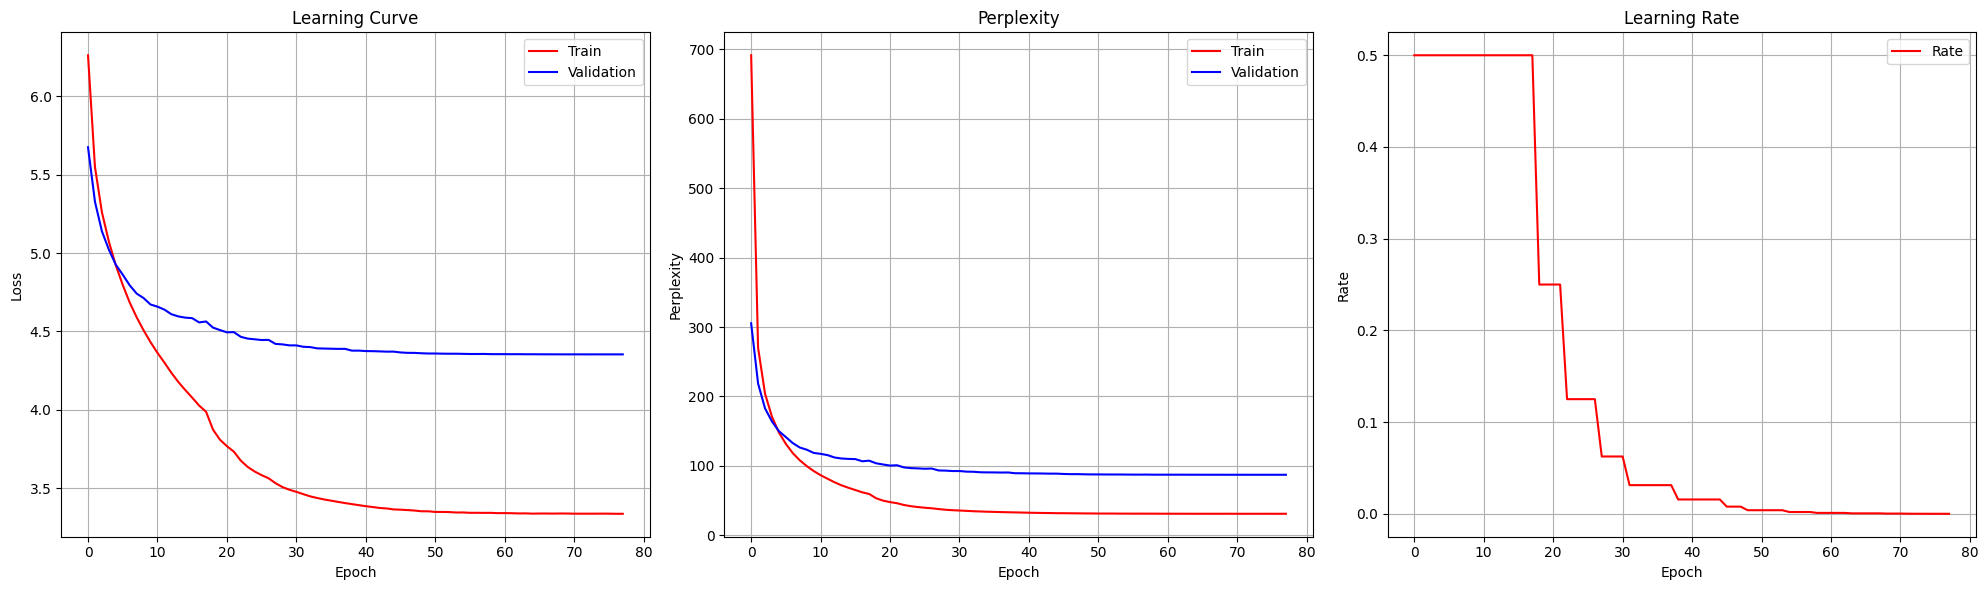

In [43]:
# Save as CSV
import pandas as pd
datas = {
    'epoch': range(epoch_counter),
    'loss_train': loss_train_hist,
    'loss_validation': loss_valid_hist,
    'perplexity_train': per_train_hist , 
    'perplexity_validation':per_valid_hist,
    'learning_rate': lr_train_hist
}
df = pd.DataFrame(datas)
df.to_csv("learningCurve.csv" , index=False)

fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
ax1.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')
ax1.set_title('Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(range(epoch_counter), per_train_hist, 'r-', label='Train')
ax2.plot(range(epoch_counter), per_valid_hist, 'b-', label='Validation')
ax2.set_title('Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True)
ax2.legend()

ax3.plot(range(epoch_counter), lr_train_hist, 'r-', label='Rate')
ax3.set_title('Learning Rate')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Rate')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

## Test Perplexity

In [44]:
model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()

loss_fn = nn.CrossEntropyLoss()
perp = Perplexity().to(device)

loss_valid , per_valid  = evaluate(model, valid_loader, loss_fn , perp )
print(f"Validation: Loss = {loss_valid:.4} , Perplexity = {per_valid:.4}")

loss_test , per_test  = evaluate(model, test_loader, loss_fn , perp)
print(f"Test: Loss = {loss_test:.4} , Perplexity = {per_test:.4}")

Validation: Loss = 4.354 , Perplexity = 87.17
Test: Loss = 4.291 , Perplexity = 79.64


# Text Generation

In [45]:
loss_fn = nn.CrossEntropyLoss()

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()
model

H_LSTM(
  (embedding): Embedding(9925, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=9925, bias=True)
)

In [46]:
num_trainable_params(model)

15.946925

In [47]:
def generate(prompt, max_seq_len, temperature, model ):

    global device
    global vocab_itos
    global seq_len
    global char2ind
    
    prompt_tokens = prompt.split(' ')
    prompt_tokens = [vocab[token] for token in prompt_tokens]  

    with torch.no_grad():
        current_token = torch.tensor(prompt_tokens).unsqueeze(0) 
        current_token = current_token.to(device)
        generated_text = prompt  
        for i in range(max_seq_len):
            output = model(current_token)
            probabilities = nn.functional.softmax(output[:, -1, :] / temperature, dim=-1)
            next_word = "<unk>"
            while next_word == "<unk>":
                next_token_id = torch.multinomial(probabilities, 1).item()
                next_word = vocab_itos[next_token_id]
            
            generated_text += " " + next_word

            next_token_id = torch.tensor([[next_token_id]]).to(device)
            if current_token.shape[1] < seq_len:
                current_token = torch.cat( ( current_token  , next_token_id ), dim=1)
            else:
                current_token = torch.cat( ( current_token[:, 1:]  , next_token_id ), dim=1)
            if next_word in ["<eos>", "."]:
                break
            del next_token_id
    return generated_text

prompt = "i think the movie"
generated_text = generate(prompt, 
                          max_seq_len = 100, 
                          temperature = 0.2, 
                          model = model)

print(generated_text)

i think the movie is n ' t as much as n n of the n people who have been in the past n years and n n in the past n years i was n ' t sure that the state ' s n n age of n n was n ' t the only reason for the future in the past n years the government ' s policy of making a sense of the government ' s ability to prevent the nation ' s second-largest airline with its own interests and the government ' s role in the u .
